In [1]:
import numpy as np
import pandas as pd
import json

### json

In [2]:
file_path = "/Users/olgaiarygina/Documents/GitHub/dc_keyboard/dc_keyboard/study_1/data_full.json"

with open(file_path, 'r') as json_file:
    data = json.load(json_file)

In [3]:
# unpacking json
records = []
for identifier, value in data.items():
    trials = value["log"]["trials"]
    for trial in trials:
        record = {
            "identifier": identifier,
            "date": value["date"], 
            "condition": value["log"]["condition"],
            "trial": trial["trial"],
            "end_time": trial["end_time"],
            "start_time": trial["start_time"],
            "target": trial["target"],
            "entered": trial["entered"],
            "part": trial["part"],
            "block": trial["block"],
        }
        records.append(record)

# df from the list of dictionaries
df = pd.DataFrame(records)

In [4]:
# app-test filtering
df.groupby('identifier')['date'].agg(list)
df['date'] = pd.to_datetime(df['date'])
df = df.loc[df['date'] >= '2023-08-10']

In [5]:
# filtering out empty trial (backend issue)
df = df.loc[df['trial'] != 32]

### metrics

In [6]:
# calculate wpm per trial
# from pypl: The WPM is calculated by dividing characters per second by five and then multiplying that with 60.

def calculate_wpm(row):
    characters_typed = len(row['entered']) # num of characters typed
    time_taken_sec = row['end_time'] - row['start_time'] # time taken
    wpm = ((characters_typed / time_taken_sec) / 5) * 60 # wpm 
    return wpm

df['wpm'] = df.apply(calculate_wpm, axis = 1)

In [7]:
# character error rate (from jiwer)
import jiwer

def calculate_cer(row):
    cer = jiwer.cer(row['target'], row['entered'])
    return cer

df['cer'] = df.apply(calculate_cer, axis = 1)

In [8]:
# low-quality data filtering

# df.nlargest(10, 'wpm')
df = df[df['identifier'] != "5689069036109824"]
len(df['identifier'].value_counts())

120

### conditions

In [9]:
for index, row in df.iterrows():
    identifier = row['identifier']
    trial_num = row['trial']
    value = data.get(str(identifier), {})

    if value:
        trials = value["log"]["trials"]

        if trial_num < len(trials):
            trial = trials[trial_num]
            condition = value["log"]["condition"]
            part = trial["part"]
            keyboard = value["log"]["ux"][part]["keyboard"]

            # Assign the extracted "keyboard" value to the DataFrame
            df.at[index, 'keyboard'] = keyboard

In [10]:
print(df['wpm'].describe())

count    7680.000000
mean       11.006539
std         3.629731
min         0.201382
25%         8.487805
50%        10.714286
75%        13.333333
max        45.333333
Name: wpm, dtype: float64


In [11]:
print(df['cer'].describe())

count    7680.000000
mean        0.012217
std         0.046551
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.892857
Name: cer, dtype: float64


### tests

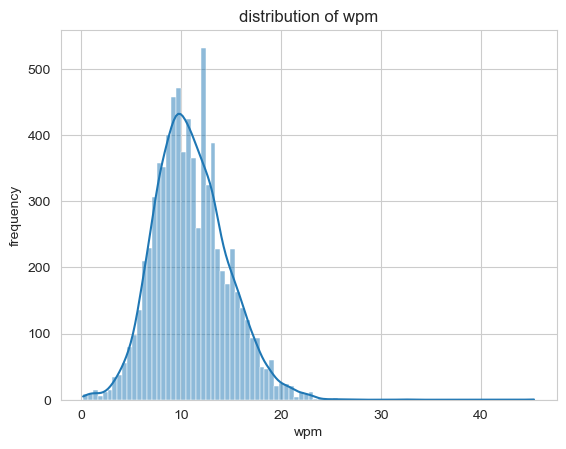

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data = df, x = 'wpm', kde = True)
plt.title('distribution of wpm')
plt.xlabel('wpm')
plt.ylabel('frequency')
plt.show()

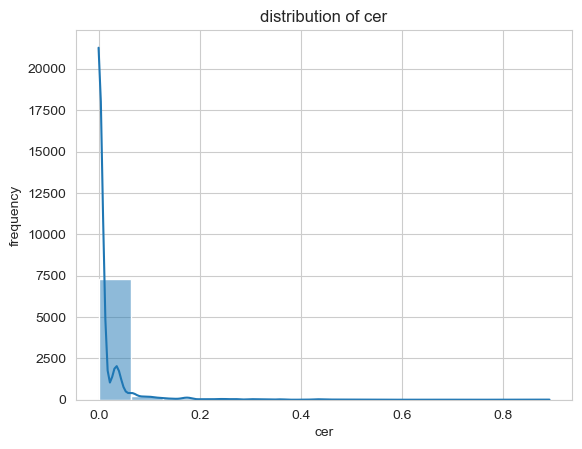

In [13]:
sns.histplot(data = df, x = 'cer', kde = True)
plt.title('distribution of cer')
plt.xlabel('cer')
plt.ylabel('frequency')
plt.show()

##### wpm

In [14]:
df['block'].value_counts() # ???

0    960
1    960
2    960
3    960
5    960
6    960
7    960
4    840
8    120
Name: block, dtype: int64

In [15]:
df['block'] = np.select(
    [
        (df['trial'] >= 0) & (df['trial'] <= 7) | (df['trial'] >= 33) & (df['trial'] <= 40),
        (df['trial'] >= 8) & (df['trial'] <= 15) | (df['trial'] >= 41) & (df['trial'] <= 48),
        (df['trial'] >= 16) & (df['trial'] <= 23) | (df['trial'] >= 49) & (df['trial'] <= 56),
        (df['trial'] >= 24) & (df['trial'] <= 31) | (df['trial'] >= 57) & (df['trial'] <= 64)
    ],
    [1, 2, 3, 4],
    default = None
)

In [16]:
import pingouin as pg

# repeated measures anova with interaction 
aov_interaction = pg.rm_anova(data = df, dv = 'wpm', within = ['keyboard', 'block'], subject = 'identifier')
print(aov_interaction)

# from statsmodels.stats.anova import AnovaRM
# aovrm = AnovaRM(df, 'wpm', 'identifier', within = ['keyboard', 'block1'], aggregate_func= 'mean')
# res = aovrm.fit()
# print(res)

             Source          SS  ddof1  ddof2         MS          F  \
0          keyboard   24.957847      1    119  24.957847   6.416492   
1             block  230.972602      3    357  76.990867  73.475403   
2  keyboard * block    3.838291      3    357   1.279430   1.260535   

          p-unc     p-GG-corr       ng2       eps  
0  1.260733e-02  1.260733e-02  0.003267  1.000000  
1  4.967836e-37  2.940488e-35  0.029437  0.948376  
2  2.877510e-01  2.878976e-01  0.000504  0.942414  


/Users/olgaiarygina/opt/anaconda3/envs/PycharmProjects/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  """Entry point for launching an IPython kernel.


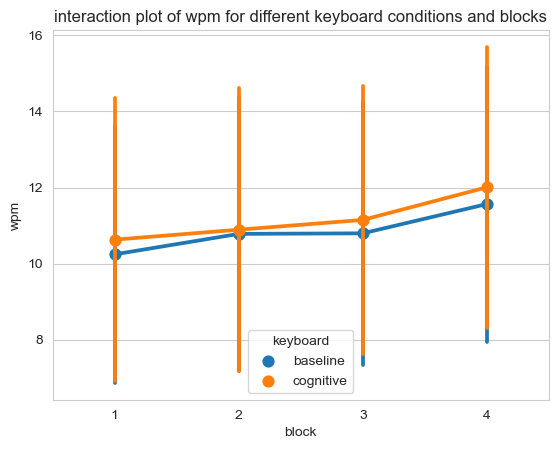

In [17]:
sns.pointplot(data = df, x = 'block', y = 'wpm', hue = 'keyboard', ci = 'sd')
plt.title('interaction plot of wpm for different keyboard conditions and blocks')
plt.xlabel('block')
plt.ylabel('wpm')
plt.show()

In [18]:
from statsmodels.stats.multicomp import MultiComparison

multi_comp = MultiComparison(df['wpm'], df['keyboard'])
post_hoc_res = multi_comp.tukeyhsd()
print(post_hoc_res.summary())

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1    group2  meandiff p-adj  lower  upper  reject
-------------------------------------------------------
baseline cognitive   0.3225 0.0001 0.1602 0.4847   True
-------------------------------------------------------


In [19]:
multi_comp = MultiComparison(df['wpm'], df['block'])
post_hoc_res = multi_comp.tukeyhsd()
print(post_hoc_res.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2      0.4 0.0032  0.1017 0.6984   True
     1      3   0.5358    0.0  0.2375 0.8341   True
     1      4   1.3494   -0.0  1.0511 1.6477   True
     2      3   0.1358 0.6462 -0.1625 0.4341  False
     2      4   0.9493   -0.0   0.651 1.2477   True
     3      4   0.8136    0.0  0.5153 1.1119   True
---------------------------------------------------


##### cer

In [20]:
cer_interaction = pg.rm_anova(data = df, dv = 'cer', within = ['keyboard', 'block'], subject = 'identifier')
print(cer_interaction)

             Source        SS  ddof1  ddof2        MS         F     p-unc  \
0          keyboard  0.000863      1    119  0.000863  0.703539  0.403279   
1             block  0.002327      3    357  0.000776  2.486615  0.060365   
2  keyboard * block  0.000507      3    357  0.000169  0.584067  0.625796   

   p-GG-corr       ng2       eps  
0   0.403279  0.000792  1.000000  
1   0.077623  0.002135  0.758408  
2   0.584002  0.000466  0.778319  


/Users/olgaiarygina/opt/anaconda3/envs/PycharmProjects/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  """Entry point for launching an IPython kernel.


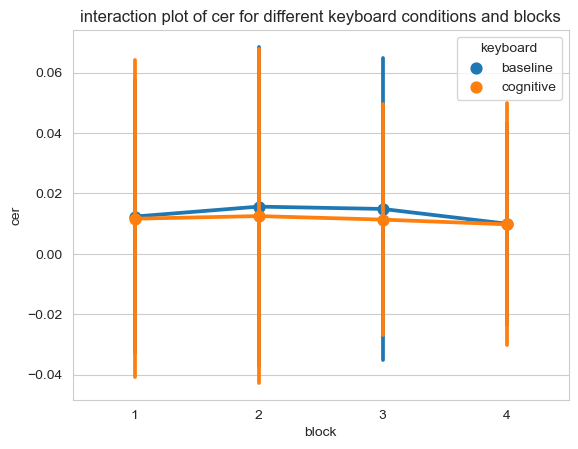

In [21]:
sns.pointplot(data = df, x = 'block', y = 'cer', hue = 'keyboard', ci = 'sd')
plt.title('interaction plot of cer for different keyboard conditions and blocks')
plt.xlabel('block')
plt.ylabel('cer')
plt.show()